In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohidbabushaik","key":"dc71d5101e82e7826917470d993e0540"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.03G/1.04G [00:04<00:00, 246MB/s]
100% 1.04G/1.04G [00:04<00:00, 246MB/s]


In [ ]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

Images directory exists.
Loaded Captions: 8091 images found.


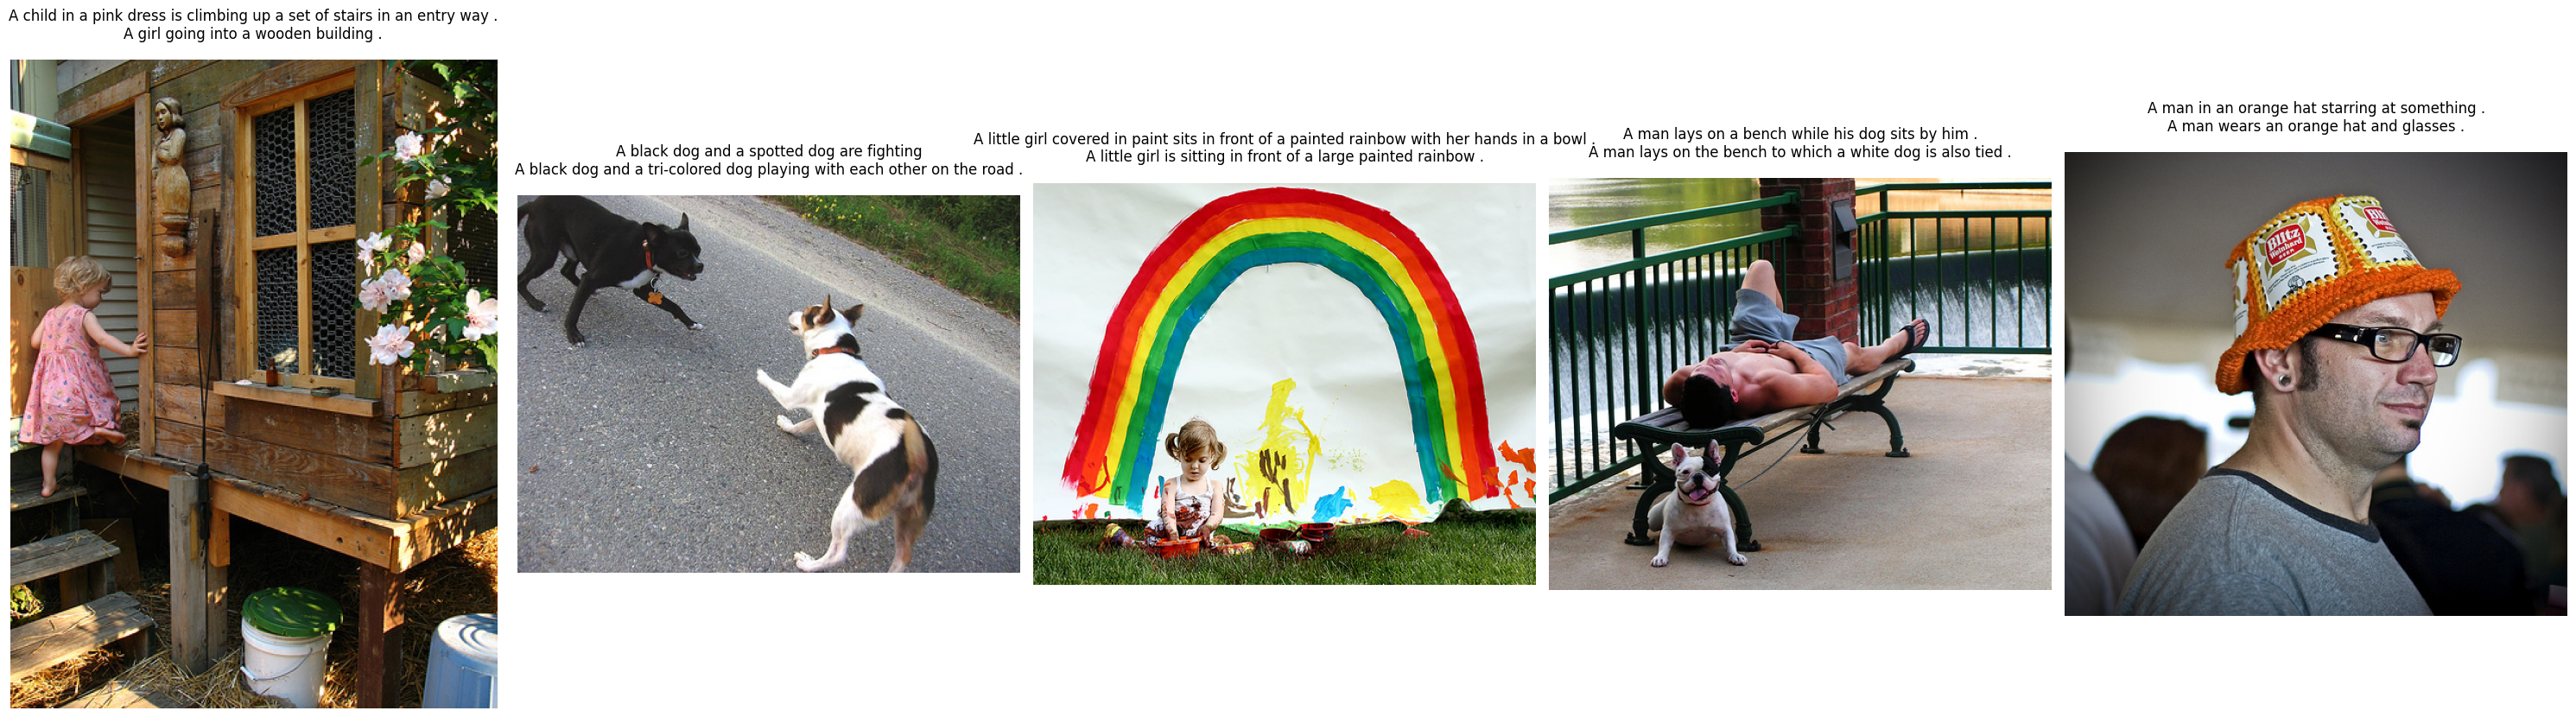

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the dataset
images_dir = "/content/Images"
captions_file = "/content/captions.txt"

# Load captions into a dictionary
def load_captions(file_path):
    captions_dict = {}
    if not os.path.exists(file_path):
        print(f"Captions file not found: {file_path}")
        return captions_dict

    with open(file_path, 'r') as f:
        # Skip the header line
        next(f)
        for line in f:
            tokens = line.strip().split(",", 1)  # Split only on the first comma
            if len(tokens) == 2:
                img_name, caption = tokens
                if img_name not in captions_dict:
                    captions_dict[img_name] = []
                captions_dict[img_name].append(caption)
            else:
                print(f"Skipping invalid line: {line.strip()}")
    return captions_dict

# Display images in a grid with captions below each image
def display_images_with_captions(images_and_captions, num_images=5):
    num_cols = min(num_images, 5)  # Max 5 images per row
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 8))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

    for idx, (image_name, captions) in enumerate(images_and_captions[:num_images]):
        ax = axes[idx]

        # Image loading
        image_path = os.path.join(images_dir, image_name)
        if not os.path.exists(image_path):
            print(f"Image {image_name} not found at {image_path}.")
            ax.axis('off')
            continue

        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')

        # Add captions below the image
        caption_text = "\n".join(captions[:2])  # Show only the first 2 captions
        ax.set_title(caption_text, fontsize=12, pad=20, loc='center', wrap=True)

    # Hide any unused subplots
    for ax in axes[len(images_and_captions[:num_images]):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Main code
if not os.path.exists(images_dir):
    print(f"Images directory not found: {images_dir}")
else:
    print("Images directory exists.")

captions = load_captions(captions_file)
print("Loaded Captions:", len(captions), "images found.")

# Prepare a list of (image_name, captions) for the first num_images
images_and_captions = list(captions.items())

# Display the images with captions
if images_and_captions:
    display_images_with_captions(images_and_captions, num_images=5)
else:
    print("No images to display.")


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = '/content/'
WORKING_DIR = '/content/'


In [ ]:
model = Xception()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

None


In [ ]:
# features extraction process from images
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
  """
  Process:
  load the image from file
  Convert image pixels to numpy array
  reshape data for model
  preprocess image for Xception net
  """
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_xception.pkl'), 'wb'))

In [ ]:
with open(os.path.join(WORKING_DIR, 'features_xception.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if not present
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [ ]:
len(mapping)

8091

In [ ]:
"""
 preprocessing steps
 --->convert to lowercase
 --->delete digits, special chars, etc.
 --->delete additional spaces
 --->add start and end tags to the caption
"""
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
          # take one caption at a time
          caption = captions[i]
          caption = caption.lower()
          caption = caption.replace('[^A-Za-z]', '')
          caption = caption.replace('\s+', ' ')
          caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
          captions[i] = caption


In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
# creating a vocubulary from all captions
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
import keras.backend as K
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0
                K.clear_session()

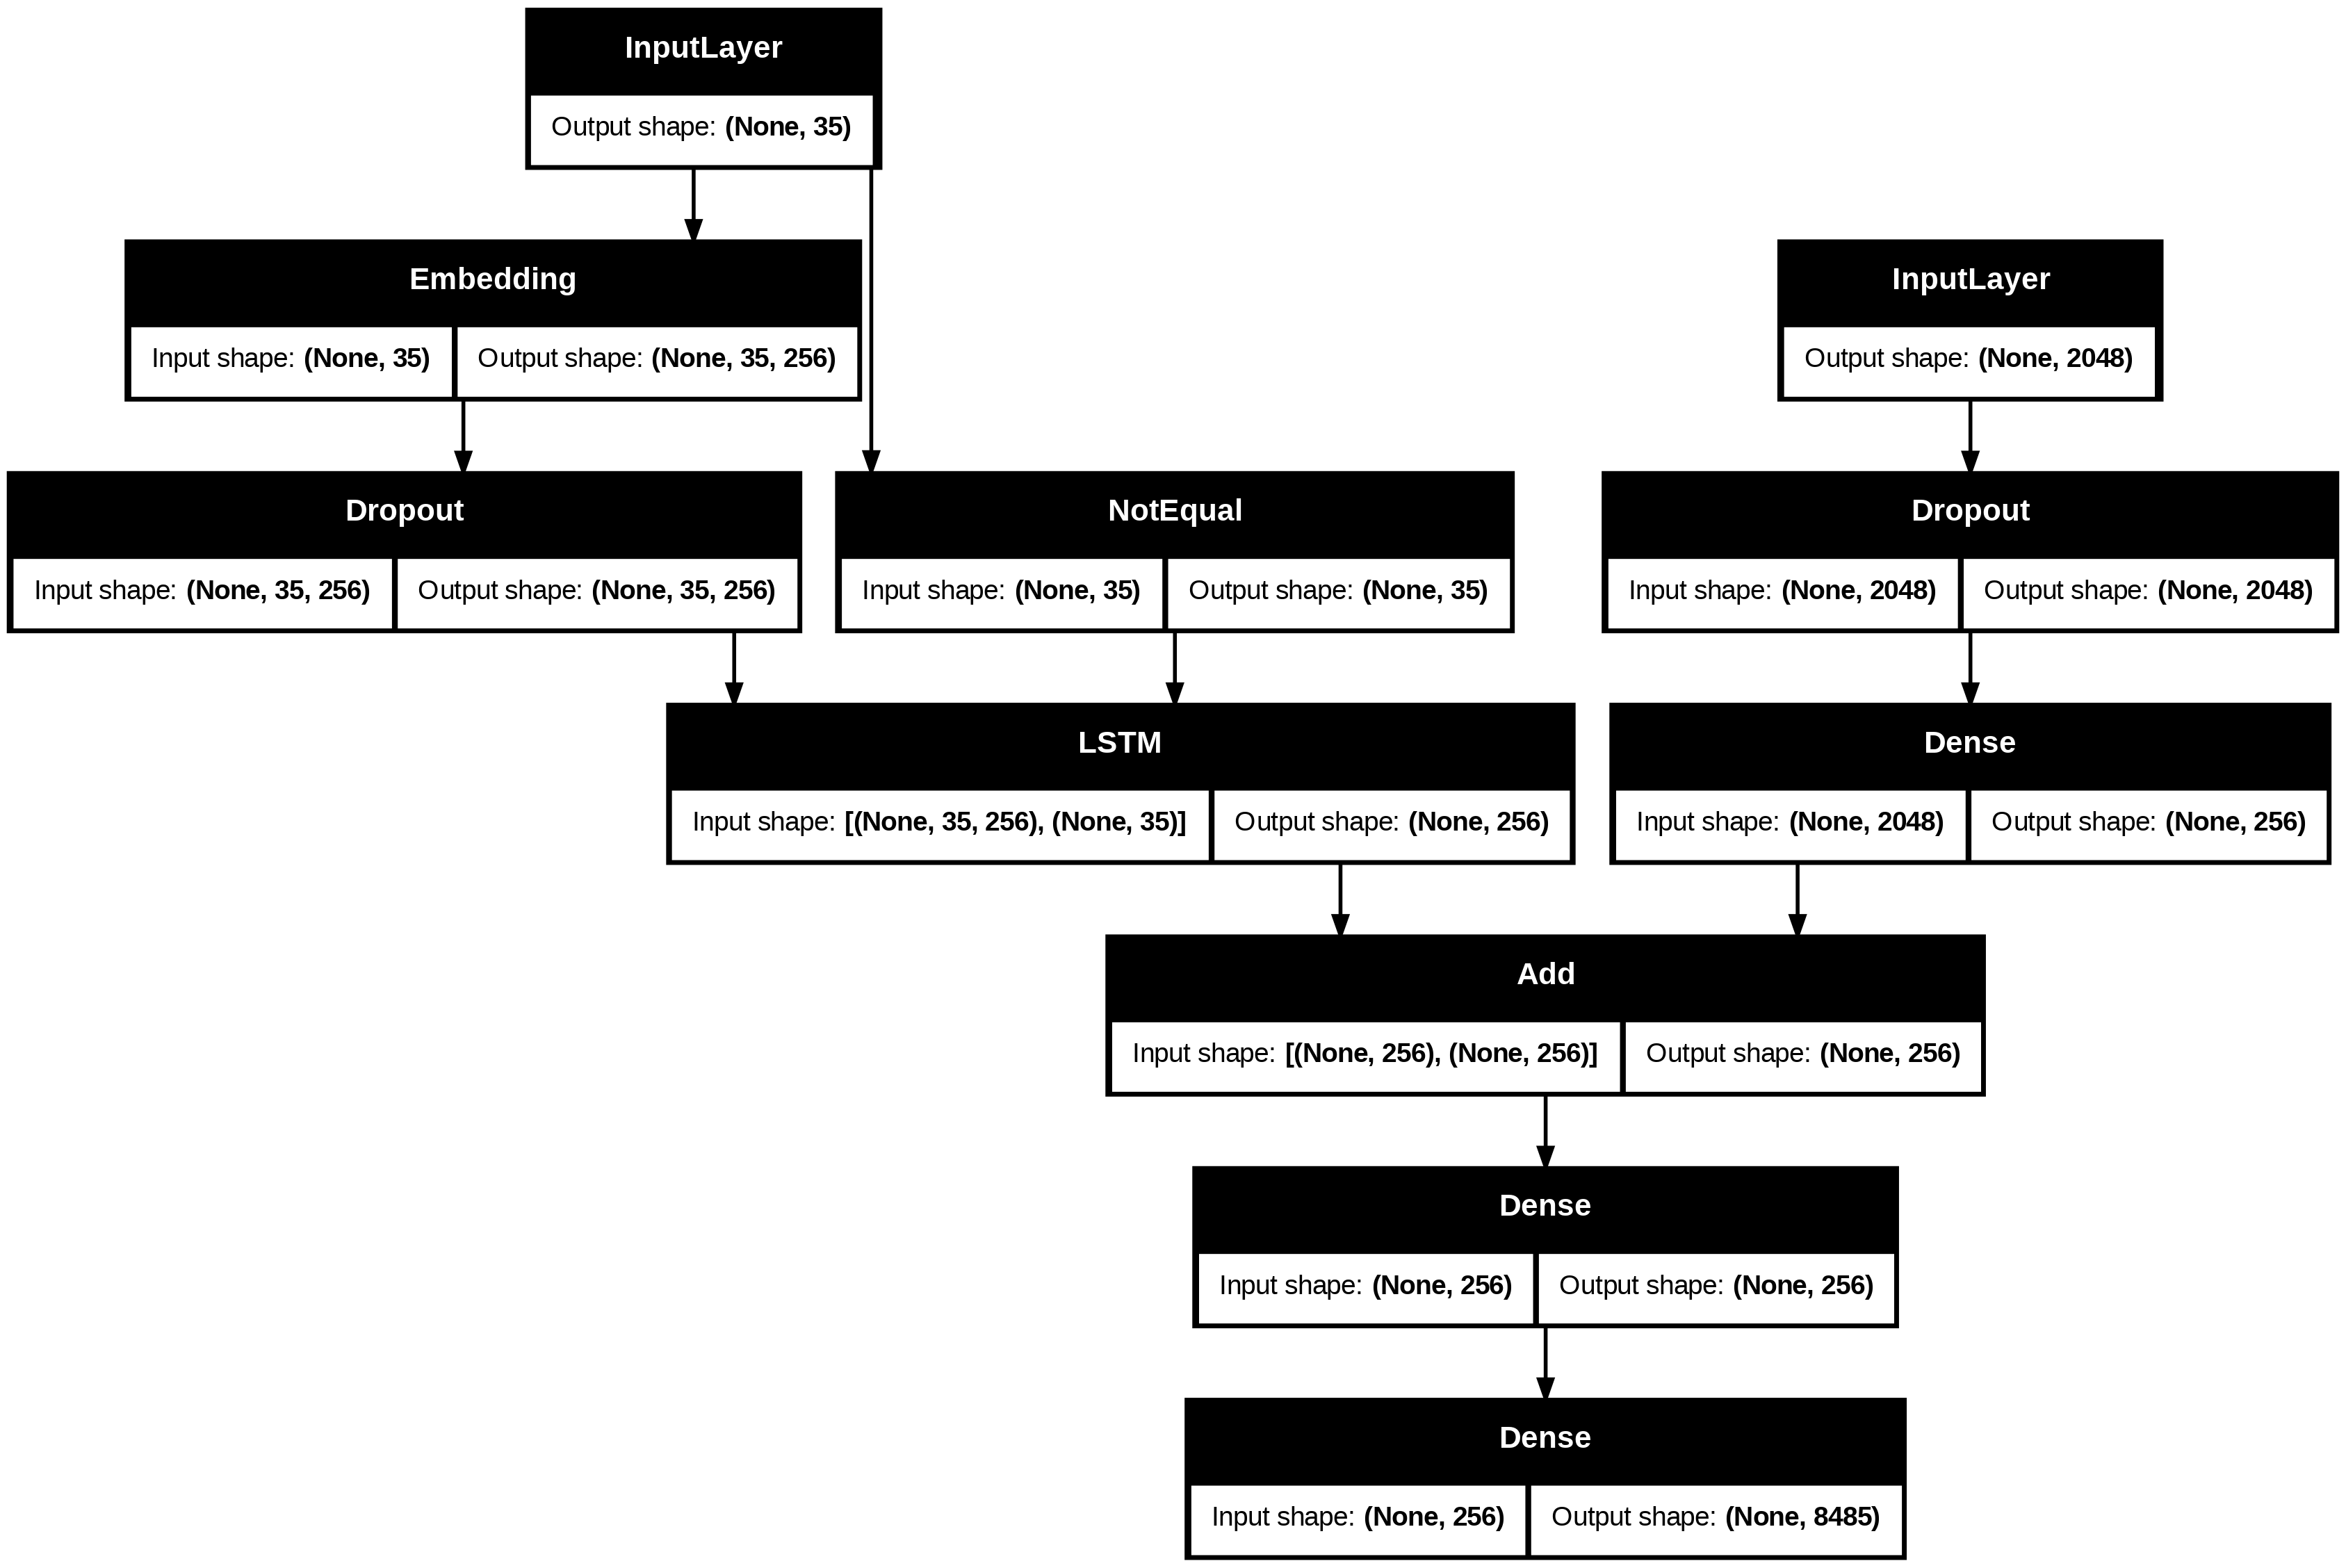

In [ ]:
# encoder model
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='leaky_relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='leaky_relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 1
batch_size = 32
steps = len(train) // batch_size
for i in range(5):
  if('best_m.sav' in os.listdir()):
    model = pickle.load(open('best_m.sav','rb'))
    print('loaded')
  for j in tqdm(range(epochs)):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs = 1, steps_per_epoch = steps,verbose = 1)
    pickle.dump(model,open('best_m.sav','wb'))
  for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/1 [00:00<?, ?it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 202s 851ms/step - loss: 6.0448
227/227 ━━━━━━━━━━━━━━━━━━━━ 190s 839ms/step - loss: 4.0402
loaded


  0%|          | 0/1 [00:00<?, ?it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 199s 875ms/step - loss: 4.0409
227/227 ━━━━━━━━━━━━━━━━━━━━ 197s 868ms/step - loss: 3.5633
loaded


  0%|          | 0/1 [00:00<?, ?it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 197s 868ms/step - loss: 3.5634
227/227 ━━━━━━━━━━━━━━━━━━━━ 196s 866ms/step - loss: 3.3022
loaded


  0%|          | 0/1 [00:00<?, ?it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 201s 886ms/step - loss: 3.3021
227/227 ━━━━━━━━━━━━━━━━━━━━ 197s 869ms/step - loss: 3.1147
loaded


  0%|          | 0/1 [00:00<?, ?it/s]

227/227 ━━━━━━━━━━━━━━━━━━━━ 195s 859ms/step - loss: 3.1156
227/227 ━━━━━━━━━━━━━━━━━━━━ 197s 869ms/step - loss: 2.9676


In [ ]:
pickle.dump(model,open('best_m.sav','wb'))

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.555337
BLEU-2: 0.329467


In [ ]:
from PIL import
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    #print('-------Predicted-------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
vgg_model = Xception()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,
                  outputs=vgg_model.layers[-2].output)

In [ ]:
from keras.models import load_model
# Load the model using custom_objects
model = pickle.load(open('/content/best_m.sav','rb'))

#model = load_model('/content/best_model.h5')
image_path = '/content/img_cp1.jpg'
# load image
image = load_img(image_path, target_size=(299, 299))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)
# import matplotlib.pyplot as plt
# imshow()

'startseq surfer rides wave endseq'

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle

base_model = Xception(weights='imagenet')
xception_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

caption_model = pickle.load(open('/content/best_m.sav', 'rb'))
with open('/content/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

max_length = 35

# Helper function to convert integer index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Generate context-based caption
def generate_context_based_caption(image_path, context_text, tokenizer, model, max_length):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(299, 299))  # Required size for Xception
    image_array = img_to_array(image)
    image = np.expand_dims(image_array, axis=0)
    image = preprocess_input(image)

    # Extract image features
    image_feature = xception_model.predict(image, verbose=0)

    # Start with context as the initial text
    in_text = f"startseq {context_text}"

    for _ in range(max_length):
        # Tokenize the current text sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)

        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += f" {word}"

    # Remove the start token and return
    context_based_caption = in_text.replace('startseq', '').strip()

    return context_based_caption

# Test the system with context
image_path = '/content/test2.jpg'
context_text = "a boy catch the ball"
predicted_caption = generate_context_based_caption(image_path, context_text, tokenizer, caption_model, max_length)

print("-------Predicted Context-Based Caption-------")
print(predicted_caption)

-------Predicted Context-Based Caption-------
a boy catch the ball for the camera
